In [3]:
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import numpy as np



In [4]:
### READ COUNTRY CHAPE FILE AND MAP TO EQUAL AREA PROJECTION
world = gpd.read_file("ne_110m_admin_0_countries.shp")
world = world.to_crs("EPSG:8857")


In [5]:
#set(world["NAME_LONG"].unique().tolist())

{'Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antarctica',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Dem. Rep. Korea',
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Falkland Islands / Malvinas',
 'Fiji',
 'Finland',
 'France',
 'French Southern and Antarctic Lands',
 'Gabon',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Greenland',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 

In [27]:
### READ BIOMES TIF AND REWRITE AS EQUAL AREA PROJECTION
src_path = "Anthropogenic_Biomes.tif"
dst_path = "Anthromes_equal_area.tif"
dst_crs  = "EPSG:8857"   # Mollweide (global equal‐area)

with rasterio.open(src_path) as src:
    transform, w, h = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width":  w,
        "height": h
    })

    with rasterio.open(dst_path, "w", **kwargs) as dst:
        for band in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, band),
                destination=rasterio.band(dst, band),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

In [28]:
### READ EQUAL AREA TIF AND GENERATE STATS
biome_tif = "Anthromes_equal_area.tif"

# Compute class counts per country
stats = zonal_stats(world, biome_tif, categorical=True, nodata=0)

# Attach results to countries dataframe
world["biome_counts"] = stats

In [29]:
world["biome_counts"]



0      {11: 3, 12: 2, 26: 24, 31: 6, 32: 238, 33: 4, ...
1      {11: 5, 12: 53, 23: 8, 24: 740, 25: 5, 26: 636...
2                    {42: 36, 43: 632, 63: 1907, 255: 7}
3      {11: 382, 12: 184, 23: 2, 25: 50, 26: 206, 31:...
4      {11: 3653, 12: 2006, 22: 75, 23: 185, 24: 193,...
                             ...                        
172    {11: 14, 12: 53, 25: 261, 26: 108, 31: 19, 32:...
173    {11: 2, 12: 4, 25: 2, 26: 22, 31: 5, 32: 166, ...
174    {12: 14, 25: 71, 26: 42, 31: 3, 32: 138, 34: 1...
175    {11: 11, 12: 8, 25: 7, 26: 20, 31: 4, 32: 75, ...
176    {12: 2, 24: 45, 26: 37, 31: 13, 32: 2750, 33: ...
Name: biome_counts, Length: 177, dtype: object

In [30]:
def normalize_counts(count_dict):
    total = sum(count_dict.values())
    return {k: v / total for k, v in count_dict.items()}

def biome_group(code):
    return {
        1: "Dense Settlements",
        2: "Villages",
        3: "Croplands",
        4: "Rangelands",
        5: "Forested",
        6: "Wildlands",
    }.get(code // 10, "Unknown")

def sum_major_biomes(counts):
    summary = {}
    for code, count in counts.items():
        group = biome_group(code)
        summary[group] = summary.get(group, 0) + count
    return summary

world["biome_proportions"] = world["biome_counts"].apply(normalize_counts)
world["major_biome_counts"] = world["biome_counts"].apply(sum_major_biomes)
world["major_biome_proportions"] = world["major_biome_counts"].apply(normalize_counts)
a = world[world["NAME"] == "France"]
print(a["biome_proportions"].values[0])
print(a["major_biome_proportions"].values[0])

{11: 0.011556373253607774, 12: 0.01926062208934629, 22: 0.001954809406082907, 23: 0.0004024607600758926, 24: 0.006324383372621169, 25: 0.050652561375265914, 26: 0.04536307709998275, 31: 0.03564652446386477, 32: 0.5779336514689818, 33: 0.0028172253205312483, 34: 0.02455010636462945, 35: 0.0005749439429655608, 41: 0.022537802564249986, 42: 0.00396711320646237, 43: 0.006381877766917726, 51: 0.04887023515207267, 52: 0.07928476973495084, 61: 0.04789283044903122, 62: 0.00011498878859311217, 255: 0.013913643419766572}
{'Dense Settlements': 0.03081699534295406, 'Villages': 0.10469729201402864, 'Croplands': 0.6415224515609728, 'Rangelands': 0.032886793537630084, 'Forested': 0.12815500488702353, 'Wildlands': 0.04800781923762433, 'Unknown': 0.013913643419766572}


In [31]:
a = world[world["NAME"] == "Germany"]
print(a["biome_proportions"].values[0])
print(a["major_biome_proportions"].values[0])

{11: 0.03303209722655033, 12: 0.06699906512932377, 22: 0.0014542432741248572, 24: 0.018489664485301757, 25: 0.12973927495585333, 26: 0.23091305702711126, 31: 0.014646307260828918, 32: 0.488625740105952, 34: 0.0023891139503479796, 41: 0.003635608185312143, 43: 0.00020774903916069389, 51: 0.005713098576919082, 52: 0.0003116235587410408, 255: 0.003843357224472837}
{'Dense Settlements': 0.1000311623558741, 'Villages': 0.3805962397423912, 'Croplands': 0.5056611613171289, 'Rangelands': 0.003843357224472837, 'Forested': 0.006024722135660123, 'Unknown': 0.003843357224472837}


In [32]:
a = world[world["NAME"] == "United Kingdom"]
print(a["biome_proportions"].values[0])
print(a["major_biome_proportions"].values[0])

{11: 0.054839187787164664, 12: 0.07677486290203053, 22: 0.0016303542315103008, 24: 0.05646954201867497, 25: 0.09307840521713354, 26: 0.0576552541870461, 31: 0.00918926930487624, 32: 0.27538165110419444, 34: 0.023566029346376166, 41: 0.13220690677338076, 42: 0.03349636875648437, 43: 0.013339261894175189, 51: 0.06684452349192234, 52: 0.04653920260856677, 61: 0.0031124944419742106, 62: 0.010819623536386542, 255: 0.04505706239810286}
{'Dense Settlements': 0.1316140506891952, 'Villages': 0.2088335556543649, 'Croplands': 0.30813694975544687, 'Rangelands': 0.1790425374240403, 'Forested': 0.11338372610048911, 'Wildlands': 0.013932117978360753, 'Unknown': 0.04505706239810286}


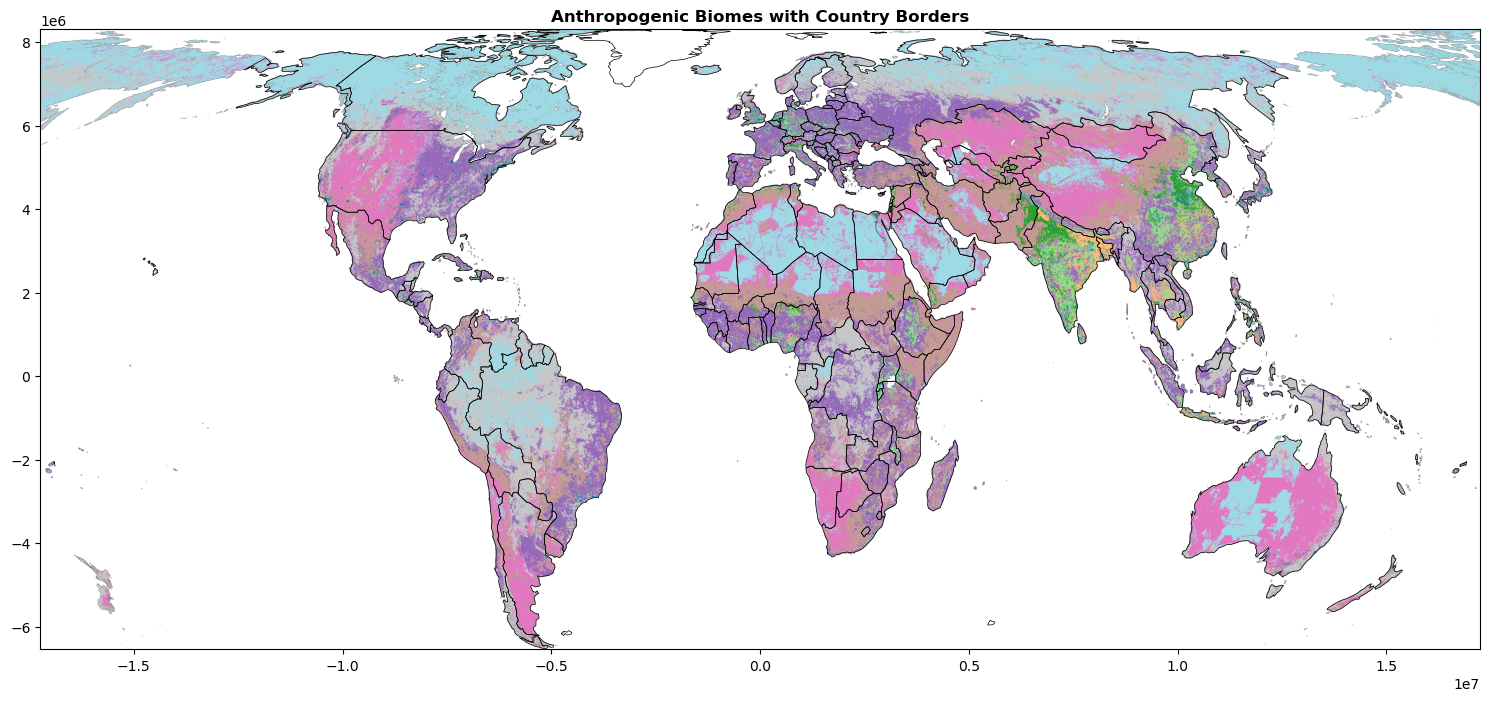

In [33]:
### PLOT SANITY CHECK
# Load raster
raster_path = "Anthromes_equal_area.tif"
src = rasterio.open(raster_path)

# Load and reproject countries to raster CRS
#world = gpd.read_file("ne_110m_admin_0_countries.shp")
#world = world.to_crs(src.crs)

# Create a plot with appropriate aspect ratio
fig, ax = plt.subplots(figsize=(15, 8))

# Plot raster using its full extent
show(src, ax=ax, cmap='tab20', title="Anthropogenic Biomes with Country Borders")

# Overlay country boundaries
world.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Set tight extent based on raster bounds
ax.set_xlim(src.bounds.left, src.bounds.right)
ax.set_ylim(src.bounds.bottom, src.bounds.top)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [34]:
set(df_g["Country"].unique().tolist()) - set(world["NAME_LONG"].unique().tolist())

{'Andorra',
 'Antigua and Barbuda',
 'Aruba',
 'Bahrain',
 'Barbados',
 'Brunei',
 'Cape Verde',
 'Comoros',
 'Dominica',
 'Eswatini',
 'Federated States of Micronesia',
 'Gambia',
 'Grenada',
 'Hong Kong',
 'Ivory Coast',
 'Kiribati',
 'Laos',
 'Macau',
 'Maldives',
 'Malta',
 'Marshall Islands',
 'Mauritius',
 'Nauru',
 'Palau',
 'Russia',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'San Marino',
 'Seychelles',
 'Singapore',
 'South Korea',
 'São Tomé and Príncipe',
 'Tonga',
 'Tuvalu'}

In [15]:
#df_g["Country"].unique().tolist()
sorted(world["NAME_LONG"].unique().tolist())

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antarctica',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Dem. Rep. Korea',
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Falkland Islands / Malvinas',
 'Fiji',
 'Finland',
 'France',
 'French Southern and Antarctic Lands',
 'Gabon',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Greenland',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 

In [10]:
df_g = pd.read_csv("gdp_capita.csv")
df_g["Country"] = df_g["Country"].apply(lambda x:x[1:])
df_g.head()

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,Afghanistan,NaN,NaN,208,201,218,253,272,330,390,441
1,Albania,"1,142","1,299","1,445","1,851","2,399","2,706","3,008","3,638","4,423","4,163"
2,Algeria,"1,948","1,919","1,958","2,305","2,840","3,258","3,691","4,208","5,215","4,262"
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,771,731,988,"1,122","1,438","2,128","2,909","3,493","4,554","3,630"


In [21]:
cmap = {"Brunei": "Brunei Darussalam", "Ivory Coast": "Côte d'Ivoire", 
        'South Korea': "Republic of Korea", "Russia": "Russian Federation", 
        "Gambia":"The Gambia", "Laos": "Lao PDR"} 

df_g["NAME_LONG"] = df_g["Country"].apply(lambda x: cmap[x] if x in cmap else x)
set(world["NAME_LONG"]) - set(df_g["NAME_LONG"].unique())

{'Antarctica',
 'Cuba',
 'Dem. Rep. Korea',
 'Falkland Islands / Malvinas',
 'French Southern and Antarctic Lands',
 'Greenland',
 'Kingdom of eSwatini',
 'New Caledonia',
 'Northern Cyprus',
 'Somaliland',
 'Western Sahara'}

In [22]:
all = world.set_index("NAME_LONG").join(df_g.set_index("NAME_LONG"), how="inner").reset_index()
all = all[["NAME_LONG", "2008", "major_biome_proportions"]]
#all["2008"] = all["2008"].apply(lambda x: x.replace(",", "") )
dict_cols = all['major_biome_proportions'].apply(pd.Series)
all = pd.concat([all, dict_cols], axis=1)
for c in ["Dense Settlements","Villages","Croplands","Forested","Unknown","Rangelands","Wildlands"]:
    all[c] = all[c].fillna(0)
all.head()

,NAME_LONG,2008,major_biome_proportions,Dense Settlements,Villages,Croplands,Forested,Unknown,Rangelands,Wildlands
0,Fiji,"4,554","{'Dense Settlements': 0.009578544061302681, 'V...",0.009579,0.045977,0.588123,0.229885,0.126437,0.000000,0.000000
1,Tanzania,684,"{'Dense Settlements': 0.0023067133312122175, '...",0.002307,0.055242,0.436685,0.111239,0.056077,0.338132,0.000318
2,Canada,"46,774","{'Dense Settlements': 0.002091887836374455, 'V...",0.002092,0.000954,0.053140,0.155007,0.070906,0.029748,0.688153
3,United States,"48,471","{'Dense Settlements': 0.022063066294465323, 'V...",0.022063,0.015154,0.327952,0.163003,0.027763,0.295849,0.148215
4,Kazakhstan,"8,514","{'Dense Settlements': 0.0012647038825049296, '...",0.001265,0.004120,0.108819,0.015992,0.017135,0.833957,0.018712


In [23]:
all["2008"] = all["2008"].apply(lambda x: float(str(x).replace(",", ""))) 
all["2008"] = np.log(all["2008"])
all = all.dropna()


In [24]:
import statsmodels.api as sm

X = all[["Dense Settlements","Villages","Croplands","Forested","Rangelands","Wildlands"]]#.to_numpy()    # independent variables
X = sm.add_constant(X)   # adds an intercept term to the model
y = all['2008'].to_numpy()              # dependent variable

# Step 2: Fit the model
model = sm.OLS(y, X).fit()

# Step 3: View the results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     8.968
Date:                Sun, 22 Jun 2025   Prob (F-statistic):           2.05e-08
Time:                        12:26:35   Log-Likelihood:                -278.48
No. Observations:                 163   AIC:                             571.0
Df Residuals:                     156   BIC:                             592.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.5687      2.08